**Limelight Code (Copy & Paste to limelight)**

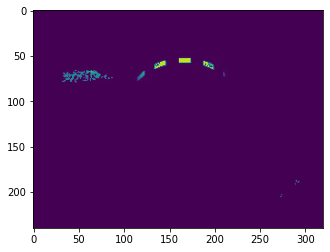

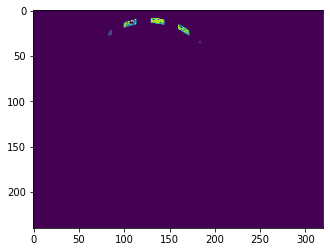

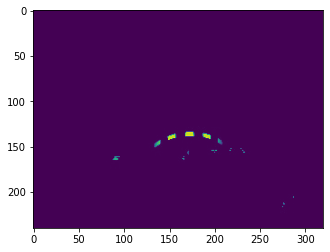

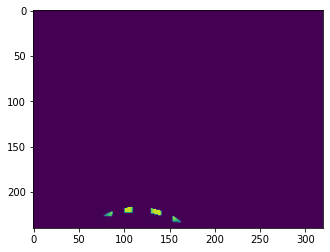

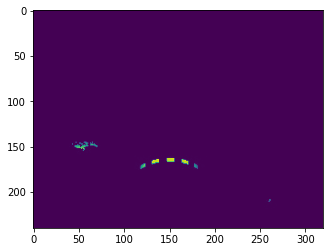

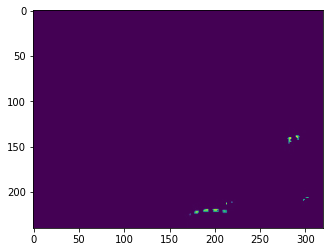

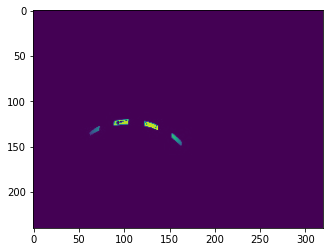

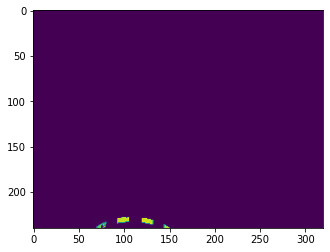

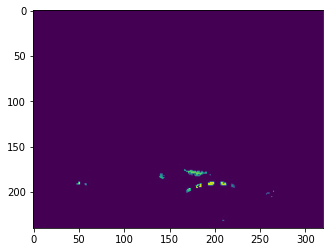

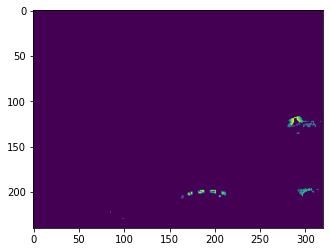

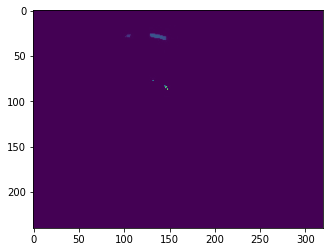

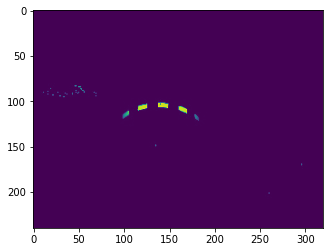

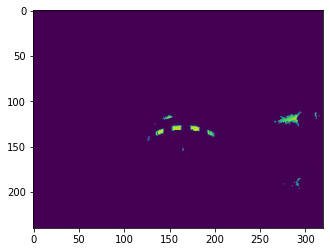

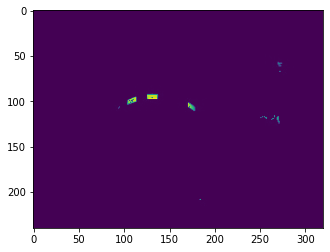

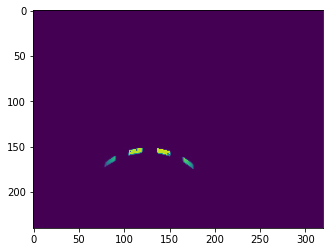

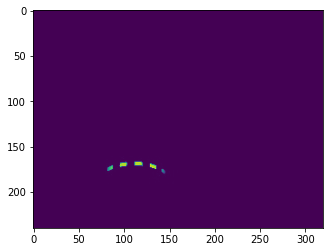

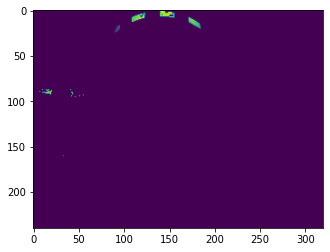

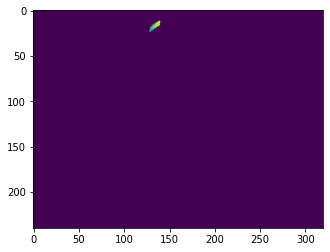

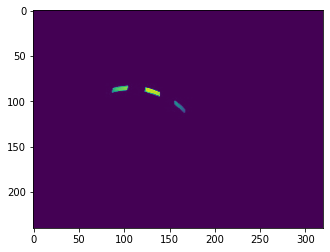

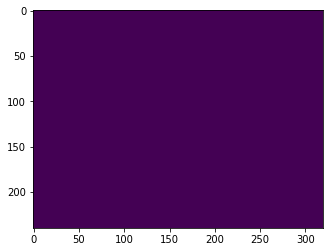

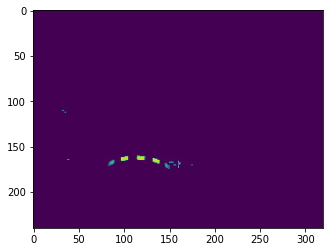

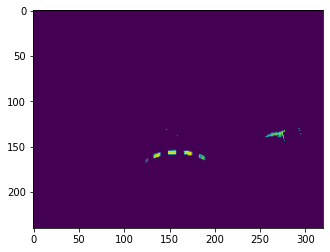

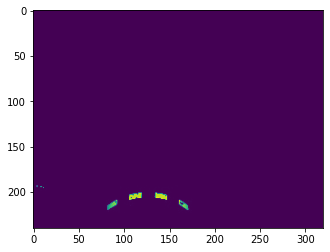

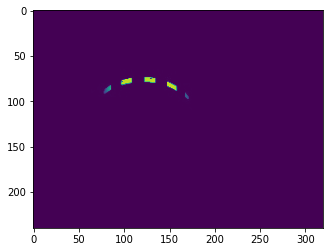

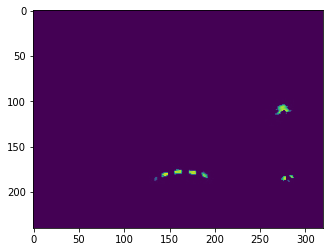

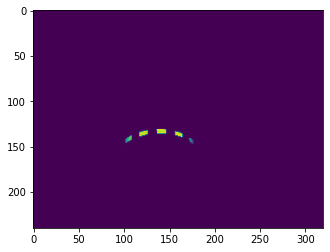

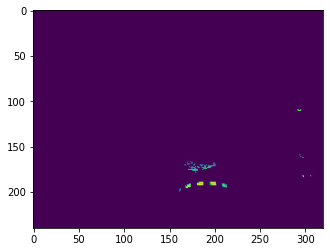

In [ ]:
#Limelight Settings:
#LED Power = 100
#Exposure = 2
#Black Level Offset = 0
#Red Balance = 2500
#Blue Balance = 1819

import cv2
import numpy as np
#import matplotlib.pyplot as plt
import math
#from networktables import NetworkTables
import skimage.color

#NetworkTables.initialize(server='10.xx.xx.2')
#table = NetworkTablesInstance.getTable('SmartDashboard')

PIXEL_BUFFER = 45

PIXELS_WIDE = 960
PIXELS_HIGH = 720
FOV_Y = 49.7

TARGET_HEIGHT = 260 
CAMERA_HEIGHT = 65
CAMERA_ANGLE = 24.5

def align_with_hub(contour):
  x, y, width, height = cv2.boundingRect(contour)
  centerX = x + width / 2
  if centerX < PIXELS_WIDE / 2 + PIXEL_BUFFER and centerX > PIXELS_WIDE / 2 - PIXEL_BUFFER:
    #perfectly align
    return 0
  elif centerX > PIXELS_WIDE / 2 - PIXEL_BUFFER:
    # move slightly right
    return 1
  else:
    # move slightly left
    return -1

def draw_contour(name):
  img = cv2.imread(name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.blur(img, (2, 2))

  imgray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # ret -> threshold value    thresh -> thresholded image
  ret, thresh = cv2.threshold(imgray, 100, 240, 0) 

  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  liz = []#list of contours with correct aspect ratio
  for contour in contours:
    x, y, width, height = cv2.boundingRect(contour)
    aspect = width/height #should be around 2.5 (5/2)
    if(aspect < 5 and aspect > 1 and height < width):
      liz.append(contour)

  if len(liz) == 0:
    return [], img 

  #finds largest contour in liz
  max = liz[0]
  for con in liz[1:]:
    if cv2.contourArea(con) > cv2.contourArea(max):
      max = con

  candidates = []#list of the largest contourS in liz
  for con in liz:
    if cv2.contourArea(max) * 0.85 <= cv2.contourArea(con):
      candidates.append(con)

  #finds the goal contour based on the rightmost contour in the 'large contours' group
  max = candidates[0]
  for con in candidates[1:]:
    maxX, _1, _2, _3 = cv2.boundingRect(max)
    currX, _1, _2, _3 = cv2.boundingRect(con)
    if currX > maxX:
      max = con

  for con in liz:
    if np.array_equal(con, max):
      x, y, w, h = cv2.boundingRect(con)
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)
    else:
      x, y, w, h = cv2.boundingRect(con)
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
  return max, img

def getDistance(contour):
  x, y, w, h = cv2.boundingRect(contour)

  norm_Y = - (y - (PIXELS_HIGH / 2)) / (PIXELS_HIGH / 2)
  pitch = np.arctan(norm_Y * np.tan(math.radians(FOV_Y / 2)))
  
  distance = (TARGET_HEIGHT - CAMERA_HEIGHT) / np.tan(math.radians(CAMERA_ANGLE) + pitch)

  return distance

def getShootingPower(distance, A=1, B=0, C=1, D=0):
  return np.clip(A * np.sqrt(C * distance + D) + B, 0, 1)

def runPipeline(image, llrobot):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imgyuv = skimage.color.rgb2yuv(image)

  meanR = [0.64853304, 0.02986617, -0.33895488]
  stddevR = [0.06069028, 0.02728164, 0.06637001]

  scale = 6
  low_threshold = np.array([0.0,
                          meanR[1] - scale * stddevR[1],
                          meanR[2] - scale * stddevR[2]])
  
  high_threshold = np.array([1.0,
                          meanR[1] + scale * stddevR[1],
                          meanR[2] + scale * stddevR[2]])

  background_mask = np.all((imgyuv > low_threshold) * (imgyuv < high_threshold), axis=2)
  background_mask = np.where(background_mask, 1, 0)
  background_mask = np.expand_dims(background_mask, 2)

  im = image * background_mask
  cv2.imwrite("mid.jpeg", im)
  goal, new_img = draw_contour("mid.jpeg")

  #If target is in sight
  if len(goal) != 0:
    alignment = align_with_hub(goal)
    distance = getDistance(goal)
    power = getShootingPower(distance)
    #table.putNumber("Turning Direction", alignment)
    #table.putNumber("Distance", distance)
    #table.putNumber("Motor Power", power)
    print('Distance: (inches)' + str(distance * 12 / 30.58))
  return goal, new_img, llrobot

**Pre-game calibration routine**

In [ ]:
def calibrate(knownimage):
  test = cv2.imread(knownimage) 

  testyuv = skimage.color.rgb2yuv(test)

  x1, x2 = 0
  y1, y2 = 0
  knownyuv = skimage.color.rgb2yuv(th[y1:y2, x1:x2])

  knownyuv = np.reshape(knownyuv, (-1, 3))

  mean_yuv = knownyuv.mean(axis = 0)
  stddev_yuv = knownyuv.std(axis = 0)

  meanR = mean_yuv
  stddevR = stddev_yuv

  test_calibrate(meanR, stddevR)

def test_calibrate(imgyuv, meanR, stddevR):
  scale = 4
  low_threshold = np.array([0.0,
                            meanR[1] - scale * stddevR[1],
                            meanR[2] - scale * stddevR[2]])

  high_threshold = np.array([1.0,
                            meanR[1] + scale * stddevR[1],
                            meanR[2] + scale * stddevR[2]])

  background_mask = np.all((imgyuv > low_threshold) * (imgyuv < high_threshold), axis=2)
  background_mask = np.where(background_mask, 1, 0)
  background_mask = np.expand_dims(background_mask, 2)

  th = th*background_mask
  plt.imshow(th)
  plt.show()